 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB
None

 Missing Values per Column:
Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

 Statistical Summary:
                           Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
count                          50530         50530.000000      50530.000000   
me

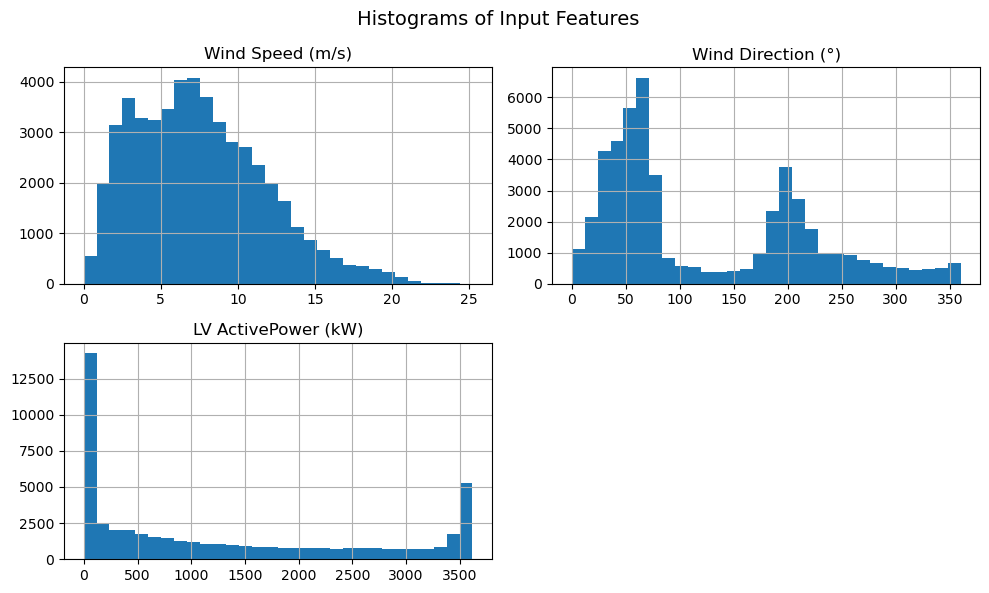

C:\Users\HP\AppData\Local\Temp\ipykernel_10540\2105941533.py:56: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from current font.
  plt.tight_layout()
C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


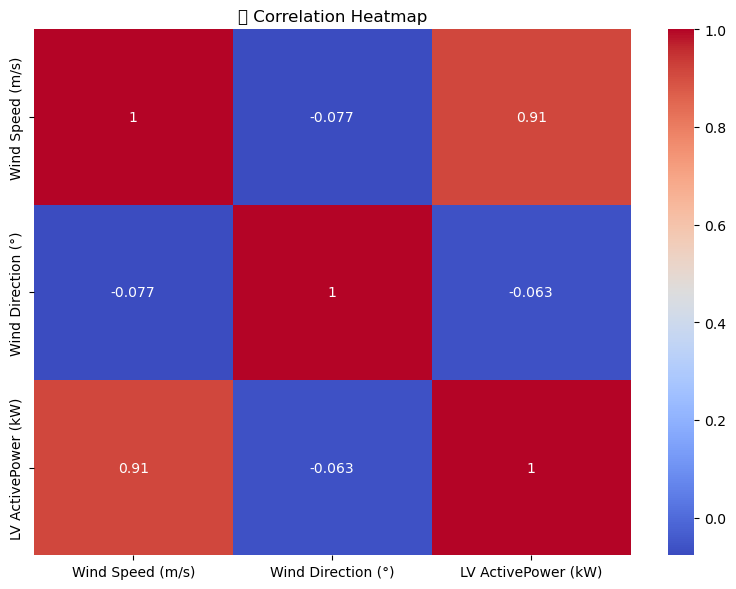

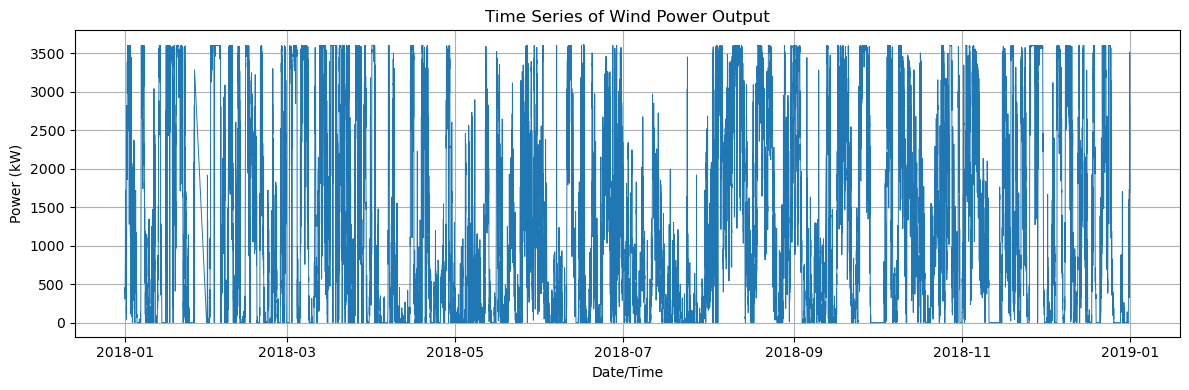

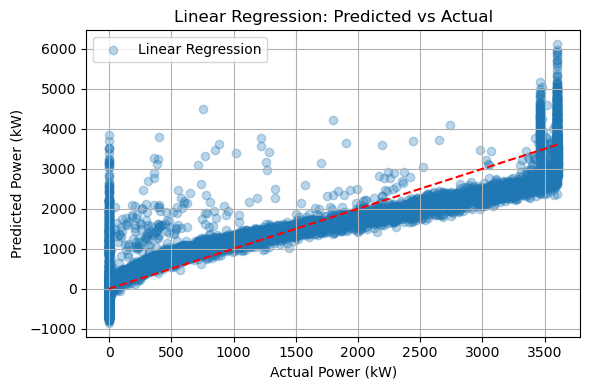

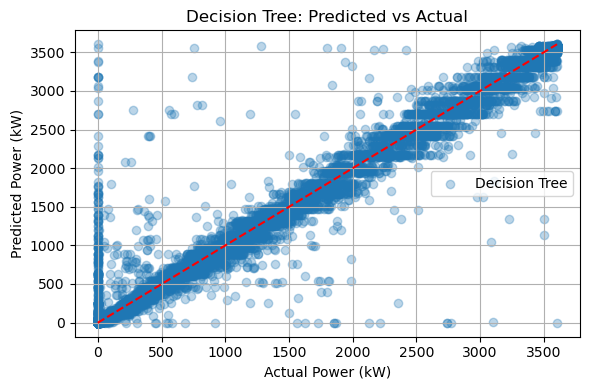

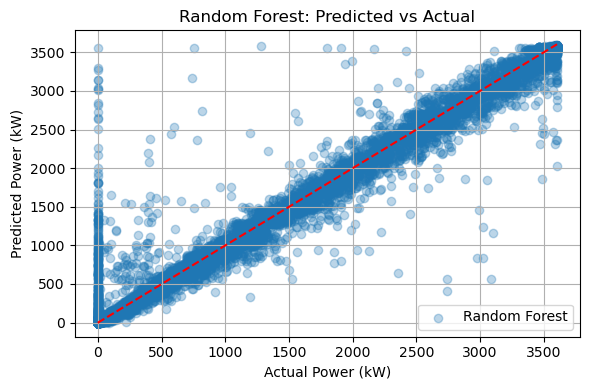

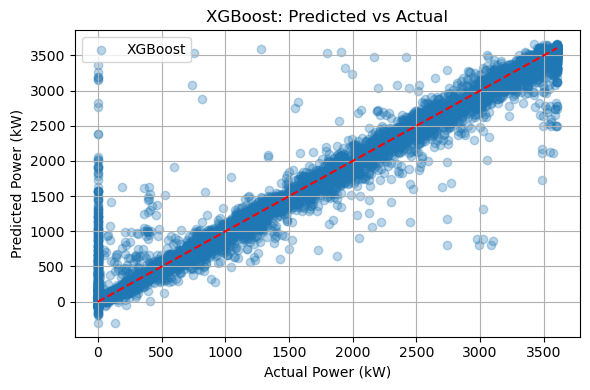

Epoch 1/10


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


569/569 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0490 - val_loss: 0.0165
Epoch 2/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0191 - val_loss: 0.0099
Epoch 3/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0149 - val_loss: 0.0086
Epoch 4/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0135 - val_loss: 0.0094
Epoch 5/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0124 - val_loss: 0.0099
Epoch 6/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0120 - val_loss: 0.0086
Epoch 7/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0122 - val_loss: 0.0101
Epoch 8/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0120 - val_loss: 0.0080
Epoch 9/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0105 - val_loss: 0.0074
Epoch 10/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0111 - val_loss: 0.0116
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


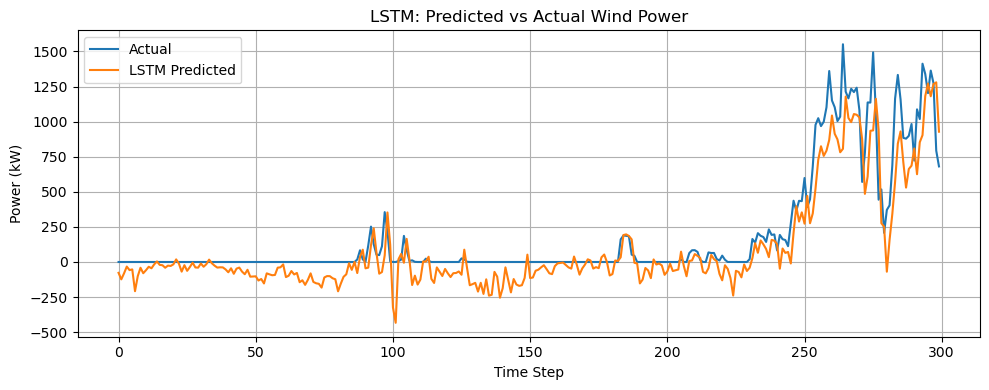

 Performance Comparison (Lower RMSE is better):
                          MAE        RMSE        R2
XGBoost             96.174676  229.685801  0.969082
Random Forest       97.672464  240.210818  0.966184
Decision Tree       99.598106  259.052277  0.960671
Linear Regression  389.898653  537.619192  0.830609
LSTM               370.890586  554.519172  0.829261


In [8]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jul  7 22:42:26 2025

@author: HP
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# =================== Load Dataset ===================
df = pd.read_csv("T1.csv")

# =================== EDA & Data Cleaning ===================

print(" Dataset Info:")
print(df.info())

print("\n Missing Values per Column:")
print(df.isnull().sum())

# Drop rows with any null values
df = df.dropna()

# Parse date with error handling
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M', errors='coerce')
df = df.dropna(subset=['Date/Time'])  # Drop rows where datetime parsing failed

# Basic stats
print("\n Statistical Summary:")
print(df.describe())

# Plot histograms
numerical_cols = ['Wind Speed (m/s)', 'Wind Direction (°)', 'LV ActivePower (kW)']
df[numerical_cols].hist(bins=30, figsize=(10, 6))
plt.suptitle(" Histograms of Input Features", fontsize=14)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("🔗 Correlation Heatmap")
plt.tight_layout()
plt.show()

# Time series of power
plt.figure(figsize=(12, 4))
plt.plot(df['Date/Time'], df['LV ActivePower (kW)'], linewidth=0.7)
plt.title("Time Series of Wind Power Output")
plt.xlabel("Date/Time")
plt.ylabel("Power (kW)")
plt.grid(True)
plt.tight_layout()
plt.show()

# =================== Feature Engineering ===================
df['Hour'] = df['Date/Time'].dt.hour
df['Day'] = df['Date/Time'].dt.day
df['Month'] = df['Date/Time'].dt.month

# Define features and target
features = ['Wind Speed (m/s)', 'Wind Direction (°)', 'Hour', 'Day', 'Month']
target = 'LV ActivePower (kW)'

X = df[features]
y = df[target]

# =================== Train-test Split for ML ===================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =================== Traditional ML Models ===================
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=20, max_depth=10, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=20, max_depth=6, random_state=42, verbosity=0)
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_pred, alpha=0.3, label=name)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Power (kW)')
    plt.ylabel('Predicted Power (kW)')
    plt.title(f'{name}: Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# =================== LSTM Model ===================

# Time series input
ts_df = df[features + [target]]
scaler_ts = MinMaxScaler()
ts_scaled = scaler_ts.fit_transform(ts_df)

# Create LSTM sequences
def create_sequences(data, n_steps=24):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :-1])
        y.append(data[i, -1])
    return np.array(X), np.array(y)

n_steps = 24  # 4 hours if 10 min data
X_lstm, y_lstm = create_sequences(ts_scaled, n_steps)

# Split LSTM data
split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

# LSTM model
model_lstm = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

# Prediction
y_pred_lstm = model_lstm.predict(X_test_lstm)

# Inverse scale
pad = np.zeros((y_pred_lstm.shape[0], ts_scaled.shape[1] - 1))
y_pred_inv = scaler_ts.inverse_transform(np.hstack((pad, y_pred_lstm)))[:, -1]
y_test_inv = scaler_ts.inverse_transform(np.hstack((pad, y_test_lstm.reshape(-1, 1))))[:, -1]

# Evaluation
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
results['LSTM'] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# LSTM Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv[:300], label='Actual')
plt.plot(y_pred_inv[:300], label='LSTM Predicted')
plt.title("LSTM: Predicted vs Actual Wind Power")
plt.xlabel("Time Step")
plt.ylabel("Power (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =================== Final Comparison ===================
print(" Performance Comparison (Lower RMSE is better):")
print(pd.DataFrame(results).T.sort_values(by='RMSE'))


you
